In [1]:
%%capture
! pip install arviz==0.11.00
! pip install pymc3==3.10.0

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pymc3 import math

from theano import tensor as tt
from scipy import stats

# Chapter 10 - Memory retention
  
This Chapter is about estimating the relationship between memory retention and time.
The model being considered is a simplified version of the exponential decay model. The model assumes that the probability that an item will be remembered after a period of time $t$ has elapsed is $\theta_{t} = \text{exp}(−\alpha t)+\beta$, with the restriction $0 < \theta_{t} < 1$. The $\alpha$ parameter corresponds to the rate of decay of information. The $\beta$ parameter corresponds to a baseline level of remembering that is assumed to remain even after very long time periods.
  
## 10.1 No individual differences


$$ \alpha \sim \text{Beta}(1,1)$$
$$ \beta \sim \text{Beta}(1,1)$$
$$ \theta_{j} = \text{min}(1,\text{exp}(−\alpha t_{j})+\beta)$$
$$ k_{ij} \sim \text{Binomial}(\theta_{j},n)$$

The above model is very sensitive to the starting value. We can specify a starting value for each parameter by assigning a `testval` when the RV is created:
```python
alpha = pm.Beta('alpha', alpha=1, beta=1, testval=.30)
```

In fact, with a bad starting value, NUTS really has a hard time sampling, and we get a `Bad initial energy` error. The reason is that bounding the theta gives 0 gradient, which is a problem as NUTS needs th gradient to work.

In [3]:
t = np.array([1, 2, 4, 7, 12, 21, 35, 59, 99, 200])
nt = len(t)
# slist = [0,1,2,3]
ns = 4
tmat = np.repeat(t, ns).reshape(nt, -1).T
k1 = np.ma.masked_values([18, 18, 16, 13, 9, 6, 4, 4, 4, -999,
                          17, 13,  9,  6, 4, 4, 4, 4, 4, -999,
                          14, 10,  6,  4, 4, 4, 4, 4, 4, -999,
                          -999, -999, -999, -999, -999, -999, -999, -999, -999, -999], 
                          value=-999).reshape(ns,-1)
n = 18

In [4]:
k1

masked_array(
  data=[[18, 18, 16, 13, 9, 6, 4, 4, 4, --],
        [17, 13, 9, 6, 4, 4, 4, 4, 4, --],
        [14, 10, 6, 4, 4, 4, 4, 4, 4, --],
        [--, --, --, --, --, --, --, --, --, --]],
  mask=[[False, False, False, False, False, False, False, False, False,
          True],
        [False, False, False, False, False, False, False, False, False,
          True],
        [False, False, False, False, False, False, False, False, False,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True]],
  fill_value=-999)

In [7]:
# t = time 
# ns = number of subjects 
# tmat = time for all subjects. 
# k1 = masked for some. 

array([  1,   2,   4,   7,  12,  21,  35,  59,  99, 200])

In [5]:
import theano
import theano.tensor as tt

In [76]:
with pm.Model() as W_et_al: 
    
    # priors 
    α = pm.Beta('α', alpha = 1, beta = 1, testval = 0.3)
    β = pm.Beta('β', alpha = 1, beta = 1, testval = 0.25)
    
    # minimum. 
    #θ = pm.Deterministic('θ', pm.math.minimum(1, pm.math.exp(-α * tmat) + β))
    θ = pm.Deterministic('θ', tt.minimum(pm.math.exp(-α * tmat) + β, 1))
    
    # likelihood function.
    y = pm.Binomial('y', p = θ, n = 18, observed = k1)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\model.py:1731: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [84]:
?pm.sample
step = pm.NUTS(target_accept=0.99) 
trace1 = pm.sample(2000, tune=2000, step=step)

SyntaxError: invalid syntax (<ipython-input-84-0764853e605f>, line 2)

In [85]:
with W_et_al: 
    
    step = pm.NUTS(target_accept=0.99) 
    trace1 = pm.sample(2000, tune=2000, step=step)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [β, α]
>Metropolis: [y_missing]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 49 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'y_missing'}>,
        <AxesSubplot:title={'center':'y_missing'}>],
       [<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

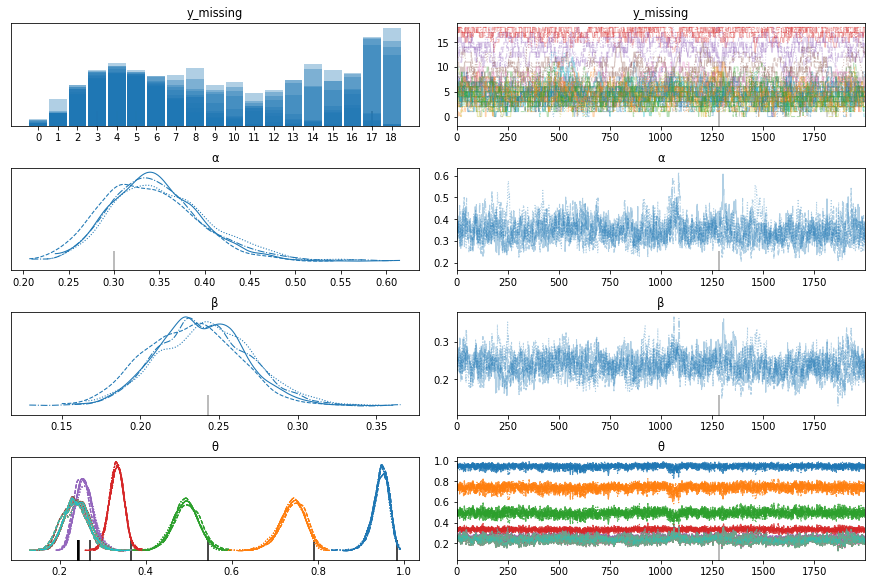

In [89]:
az.plot_trace(trace1, legend = False, compact = True)

In [90]:
az.summary(trace1, var_names = ['α', 'β'])

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,0.347,0.053,0.249,0.445,0.004,0.003,217.0,217.0,207.0,514.0,1.02
β,0.238,0.030,0.183,0.294,0.002,0.002,178.0,178.0,177.0,590.0,1.03


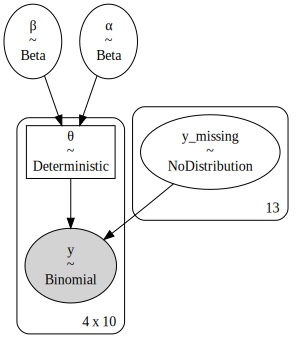

In [91]:
## posterior predictive
pm.model_to_graphviz(W_et_al)

In [23]:
# posterior stuff
with W_et_al:
    post = pm.sample_posterior_predictive(beta_test)

In [69]:
# first participant first timestep. 
post["y"][:, 0, 0]

array([18, 16, 18, ..., 18, 18, 18])

In [72]:
participant = [0, 1, 2, 3]
timestep = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [73]:
?np.stack

In [ ]:
something = np.empty()
for j in timestep: 
    np.stack(something, post["y"][:, 0, j])

In [70]:
for i in participant: 
    for j in timestep: 
        post["y"][:, 0, 0]

array([[[18, 15,  9, ...,  6,  2,  5],
        [18, 16, 12, ...,  8,  3,  2],
        [18, 12,  9, ...,  3,  3,  5],
        [18, 15,  6, ...,  3,  3,  6]],

       [[16, 16, 10, ...,  7,  5,  4],
        [18, 12,  6, ...,  4,  7,  5],
        [17, 16,  8, ...,  5,  3,  4],
        [18, 14, 10, ...,  4,  5, 10]],

       [[18, 11,  8, ...,  3,  2,  3],
        [18, 14, 10, ...,  7,  6,  5],
        [16, 13,  9, ...,  3,  4,  3],
        [17, 13, 10, ...,  3,  6,  6]],

       ...,

       [[18, 15,  8, ...,  0,  4,  2],
        [17, 15,  9, ...,  3,  6,  4],
        [17, 14,  8, ...,  2,  4,  3],
        [16, 14,  8, ...,  2,  3,  2]],

       [[18, 14, 14, ...,  5,  7,  2],
        [17, 13,  9, ...,  4,  3,  4],
        [18, 14,  6, ...,  3,  4,  4],
        [18, 15, 13, ...,  5,  3,  2]],

       [[18, 12,  6, ...,  3,  3,  5],
        [17, 12,  9, ...,  3,  2,  4],
        [16, 14,  6, ...,  4,  4,  0],
        [18, 14, 14, ...,  5,  5,  4]]])

In [21]:
?pm.sample_posterior_predictive